In [33]:
import pandas as pd

df = pd.read_csv('gs://rob_buck/loan.csv')
df.head()

/var/tmp/ipykernel_9260/2369202826.py:3: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('gs://rob_buck/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df.shape

(2260668, 145)

In [35]:
df['is_default'] = df['loan_status'].map({
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1
})

In [36]:
key_features = [
    'grade', 'int_rate', 'home_ownership', 'revol_util', 
    'loan_amnt', 'annual_inc', 'dti',
    'term', 'verification_status', 'inq_last_6mths', 
    'open_acc', 'pub_rec', 'total_acc', 
    'earliest_cr_line', 'acc_now_delinq',
    'is_default'
]

In [37]:
df = df[key_features]

In [38]:
df.shape

(2260668, 16)

In [39]:
df.isnull().sum() 

grade                     0
int_rate                  0
home_ownership            0
revol_util             1802
loan_amnt                 0
annual_inc                4
dti                    1711
term                      0
verification_status       0
inq_last_6mths           30
open_acc                 29
pub_rec                  29
total_acc                29
earliest_cr_line         29
acc_now_delinq           29
is_default                0
dtype: int64

In [8]:
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].mean())
df['dti'] = df['dti'].fillna(df['dti'].median())
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(df['delinq_2yrs'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['emp_length'] = df['emp_length'].fillna('Unknown')

In [9]:
df.isnull().sum() 

loan_amnt         0
int_rate          0
grade             0
annual_inc        0
dti               0
delinq_2yrs       0
revol_util        0
emp_length        0
home_ownership    0
purpose           0
is_default        0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder

# OneHot encode categorical columns directly
for col in ['grade', 'emp_length', 'home_ownership', 'purpose']:
   encoder = LabelEncoder()
   df[col] = encoder.fit_transform(df[col])

df.head()

,loan_amnt,int_rate,grade,annual_inc,dti,delinq_2yrs,revol_util,emp_length,home_ownership,purpose,is_default
0,2500,13.56,2,55000.0,18.24,0.0,10.3,1,5,2,0
1,30000,18.94,3,90000.0,26.52,0.0,24.2,1,1,2,0
2,5000,17.97,3,59280.0,10.51,0.0,19.1,6,1,2,0
3,4000,18.94,3,92000.0,16.74,0.0,78.1,1,1,2,0
4,30000,16.14,2,57250.0,26.35,0.0,3.6,1,1,2,0


In [11]:
df.columns

Index(['loan_amnt', 'int_rate', 'grade', 'annual_inc', 'dti', 'delinq_2yrs',
       'revol_util', 'emp_length', 'home_ownership', 'purpose', 'is_default'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('is_default', axis=1), df['is_default'], test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (1808534, 10)
X_test_scaled shape: (452134, 10)


In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [16]:
gb_param_dist = {
    'n_estimators': randint(200, 1000),
    
    'learning_rate': uniform(0.01, 0.2),  # 0.01 to 0.21
    
    'max_depth': randint(3, 10),
    
    'min_samples_split': randint(10, 100),
    
    'min_samples_leaf': randint(5, 50),
    
    'subsample': uniform(0.7, 0.3),  # 0.7 to 1.0
    
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
    
    'min_weight_fraction_leaf': uniform(0.0, 0.1),
    
    'ccp_alpha': uniform(0.0, 0.01),
    
    'validation_fraction': uniform(0.1, 0.1),  # 0.1 to 0.2
    
    'tol': uniform(1e-5, 1e-3),
    
    'n_iter_no_change': randint(5, 20)
}


In [17]:
gb_model = GradientBoostingClassifier(
    random_state=42,
    warm_start=False,
    verbose=1  # Show progress during training
)

# Set up RandomizedSearchCV with optimized settings for large datasets
gb_random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation (faster for large datasets)
    scoring='roc_auc',  # Optimize for ROC-AUC
    n_jobs=-1,  # Use all CPU cores
    verbose=2,  # Show detailed progress
    random_state=42,
    return_train_score=True
)

In [18]:
gb_random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7626          -0.0000           35.46m
         2           0.7619          -0.0026           36.28m
         3           0.7505           0.0147           36.04m
         4           0.7504          -0.0004           35.67m
         5           0.7513           0.0036           35.54m
         6           0.7516           0.0011           35.33m
         7           0.7493          -0.0093           35.46m
         8           0.7500           0.0027           35.55m
         9           0.7512           0.0050           36.24m
        10           0.7501          -0.0045           36.35m
[CV] END ccp_alpha=0.003745401188473625, learning_rate=0.20014286128198325, max_depth=5, max_features=0.7, min_samples_leaf=25, min_samples_split=92, min_weight_fraction_leaf=0.00999749158180029, n_estimators=658, n_iter_no_change=12, subsample=0.80011258

,estimator,"GradientBoost...42, verbose=1)"
,param_distributions,"{'ccp_alpha': <scipy.stats....x7fa4abe9b370>, 'learning_rate': <scipy.stats....x7fa4abe98b80>, 'max_depth': <scipy.stats....x7fa4abe9a7a0>, 'max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [24]:
best_gb_model = gb_random_search.best_estimator_

gb_pred_proba = best_gb_model.predict_proba(X_test_scaled)[:, 1]
gb_pred_binary = best_gb_model.predict(X_test_scaled)

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)
gb_accuracy = accuracy_score(y_test, gb_pred_binary)

print(f"\nTest Set Performance:")
print(f"ROC-AUC Score: {gb_roc_auc:.4f}")
print(f"Accuracy Score: {gb_accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, gb_pred_binary))


Test Set Performance:
ROC-AUC Score: 0.6900
Accuracy Score: 0.8722

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    394330
           1       0.00      0.00      0.00     57804

    accuracy                           0.87    452134
   macro avg       0.44      0.50      0.47    452134
weighted avg       0.76      0.87      0.81    452134



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [27]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_gb_model.feature_importances_  
}).sort_values('importance', ascending=False)  

feature_importance

,feature,importance
2,grade,0.672443
1,int_rate,0.295058
8,home_ownership,0.011743
6,revol_util,0.007154
0,loan_amnt,0.005413
3,annual_inc,0.004411
4,dti,0.003777
5,delinq_2yrs,0.000000
7,emp_length,0.000000
9,purpose,0.000000


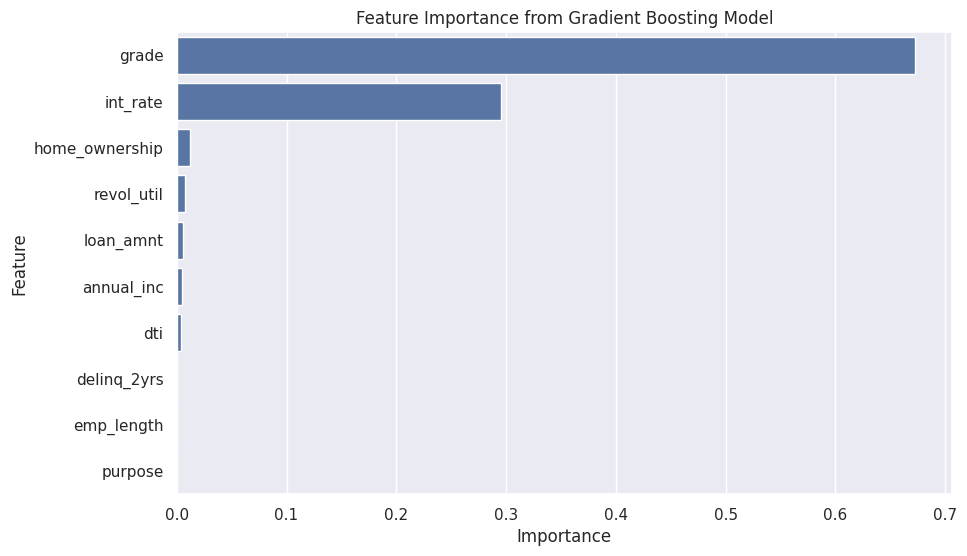

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance from Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()